# Learning Tonotactic Patterns over Autosegmental Representation with BUFIA
---


## Part 1 Convert String to ASR

In [11]:
# -*- coding: utf-8 -*-
import os
import re
import pandas as pd
import graphviz

class Autorep:
    
    def __init__(self, word="", mel='', reduced_mel="", assoc=None):
        """
        Initialize an Autorep object.

        Parameters:
        - word (str): The word with tone markers. Default is an empty string.
        - tone (str): The tone markers directly extracted from the word(HFLR). Default is an empty string.
        - mel (str): The melody (F -> HL and R -> LH) before OCP. Default is an empty string.
        - reduced_mel (str): The OCP-applied tone representation of the word. Default is an empty string.
        - assoc (list): A list of tuples (j,k) indicating the association between tone (indexed by j) and syllable (indexed by k) list.
        """
        self.word = word
        self.tone = ''
        self.mel = ''
        self.reduced_mel = reduced_mel
        self.assoc = assoc if assoc is not None else []

        h_tone = "áéíóú"
        l_tone = "àèìòù"
        f_tone = "âêîôû"
        r_tone = "ǎěǐǒǔ"


        
        if len(self.reduced_mel) != max([j for j, k in self.assoc if j is not None], default=0):
            raise ValueError("The length of the melody does not match the number of tone units.")
        
        if not reduced_mel: #if tone is specified convert to OCP melody
            self.tone_labels = {'H': h_tone, 'L': l_tone, 'F': f_tone, 'R': r_tone}
            self.tone += ''.join(next((k for k, v in self.tone_labels.items() if seg in v), '') for seg in self.word)
            self.mel = self.tone 

            # Convert 'F' and 'R' into 'HL' and 'LH' respectively
            for i in range(len(self.tone)):
                contour_count = 0 
                self.assoc.append((i + 1, i + 1)) 
                if self.tone[i] == 'F':
                    k, v = self.assoc[i]
                    self.mel = self.mel.replace('F', 'HL')
                    self.assoc.insert(2 * i + 1, (i + contour_count, i + 1))
                elif self.tone[i] == 'R':
                    k, v = self.assoc[i]
                    self.mel = self.mel.replace('R', 'LH')
                    self.assoc.insert(2 * i + 1, (i + contour_count, i + 1))

            # Adjust association indices
            for i in range(1, len(self.mel)):
                j, k = self.assoc[i]
                p, q = self.assoc[i - 1]
                if self.mel[i] == self.mel[i - 1]:
                    for j in range(i, len(self.assoc)):
                        self.assoc[j] = (self.assoc[i - 1][0], self.assoc[j][1])
                else:
                    j = p + 1
                    self.assoc[i] = (j, k)

            self.reduced_mel = re.sub(r"(.)\1+", r"\1", self.mel)

        #print(self.mel, self.reduced_mel, self.assoc) 
    
    def check_empty(self):
        return (self.word == "" and self.assoc == [] and self.mel == "" and self.reduced_mel == "")     


    def tone_pos(self, check_tone):
        """
        Get positions of a particular tone in the melody.
        """
        check_tone = check_tone.upper()
        if check_tone not in set(self.mel):
            return False     
        else:
            return [1 + i for i, j in enumerate(self.mel) if j == check_tone]      
    
    @staticmethod
    def index_reset(lst):
        """
        Reset indices of the association list to start from 1.
        """
        j, k = lst[0] if lst else (None, None)
        distance_k = k - 1 if k is not None else None
        distance_j = j - 1 if j is not None else None
        new_list = []
        for (j, k) in lst:
            j = j - distance_j if j is not None and distance_j is not None else None
            k = k - distance_k if k is not None and distance_k is not None else None
            new_list.append((j, k))
        return new_list 
    
    @staticmethod
    def assoc_check(assoc_list):
        if assoc_list:
            for tup in assoc_list:
                if None not in tup:
                    return True  # At least one tuple doesn't contain None, so return True
            return False  # Every tuple contains a None value, so return False
        else:
            return False
   
    def assoc_number(self):
        return sum(1 for tup in self.assoc if tup[0] is not None and tup[1] is not None)
   
    @staticmethod
    def sort_assoc(assoc):
        """
        Sorts the association list.

        unsorted_assoc = [(1, 1), (None, 3), (2, 1), (None, 4), (3, None)])
        sorted_assoc = [(1, 1), (2, 1), (None, 3), (3, None), (None, 4)]
        """
        
        def custom_compare(x):
            if x is None:
                return float('inf')  # Treat None bigger than any other value
            else:
                return x
            
        sorted_assoc = sorted(assoc, key=lambda x: (custom_compare(x[1] if x[1] != None else x[0]),custom_compare(x[0] if x[0] != None else x[1])))
        return sorted_assoc

    
    def syl_num(self):
        return max([k for j, k in self.assoc if k is not None], default=0)
        
    
    def check_contain(self, ar):
        """
        Check if the Autorep object contains another Autorep object.
        """ 
        
        self.assoc = self.sort_assoc(self.assoc) #sort associations, put floating right side
        ar.assoc = ar.sort_assoc(ar.assoc)
        
        if self.check_empty() or ar.check_empty(): # empty ar contains nothing and everything contains empty
            return False if not ar.check_empty() else True 
        
        elif ar == self: #reflexivity 
            return True
        
        if ar.reduced_mel not in self.reduced_mel: # check tonal tier: tonal string of containee is the substring of container
            return False 

        if ar.syl_num() > self.syl_num() or ar.assoc_number() > self.assoc_number(): # container's associations and syllables >= 
            return False

        check_positions = [m.start()+1 for m in re.finditer(r'(?={})'.format(ar.reduced_mel), self.reduced_mel)]

        for i_match in check_positions:
            window_size = ar.assoc_number()
            scan_time = sum(tup[0] for tup in self.assoc if tup[0] == i_match)

            for i in range(scan_time):
                if self.index_reset(self.assoc[i_match-1+i:i_match+window_size-1+i]) == [tup for tup in ar.assoc if not (tup[0] is None or tup[1] is None)]:
                    return True

        return False



    def add_tone(self):
        """
        Add an unassociated tone in the AR by adding a tone to the melody and an association (j,k)
        j is one-unit increase of the tone numbers
        k is 'None' indicating the syllable is not associated with any tone unit
        """
        new_assoc = self.assoc.copy() 
        
        if self.reduced_mel == '':
            new_assoc.append((1, None))
            new_autorep = [
                Autorep(reduced_mel='H', assoc=new_assoc),
                Autorep(reduced_mel='L', assoc=new_assoc)
            ]
        else:
            if len(self.reduced_mel) == 1:
                new_reduced_mel = "HL" if self.reduced_mel == "H" else "LH"
            else:
                new_reduced_mel = self.reduced_mel + self.reduced_mel[-2] 
            new_assoc.append((len(new_reduced_mel), None))
            new_autorep = [Autorep(reduced_mel=new_reduced_mel, assoc=new_assoc)]
        
        return new_autorep



    def add_syl(self):
        """
        Add an unassociated syllable in the AR by adding an assocation (j,k)
        j is 'None' indicating the syllable is not associated w any tone unit
        k is the one-unit increase of current syllable number (the variable max_syllable)
        """
        current_syl = [k for j,k in self.assoc if k is not None]
    
        if current_syl:
            max_syllable_index = max(current_syl)
            new_assoc = self.assoc.copy()  # Create a copy to avoid modifying the original assoc list
            new_max_syllable_index = max_syllable_index +1
            new_assoc.append((None, new_max_syllable_index))
            new_autorep = [Autorep(mel = self.mel, reduced_mel = self.reduced_mel, assoc=new_assoc)]
        else:
            new_autorep = [Autorep(mel = self.mel, reduced_mel = self.reduced_mel, assoc=self.assoc + [(None, 1)])]
        
        return new_autorep
    

    def float_tone(self):
        if len(self.assoc) > 1:
            return ([(_,k) for (_,k) in reversed(self.assoc) if k is None][::-1])
        else:
            return ([(_,k) for (_,k) in self.assoc if k is None])
    

    def float_syl(self):
        return [(j,_) for (j,_) in reversed(self.assoc) if j is None][::-1]

    
    def check_float(self):
        return any([self.float_tone(),self.float_syl()])


    def float_tone_to_syl(self):
        """
        Associate the first floating tone to the last syllable
        e.g LH [(1,1), (2,None)] -> [(1,1), (2,1)]
        """
        if self.float_tone():
            doubly_linked_pair = [(j,k) for (j,k)in self.assoc if j is not None and k is not None]
            if doubly_linked_pair:
                last_valid_tuple = max(doubly_linked_pair)
                t,s = last_valid_tuple
                first_float_tone = min(((j,k) for (j,k)in self.assoc if k is None), default=(float('inf'), None))
                k,_ = first_float_tone
                first_float_tone_index = self.assoc.index(first_float_tone)
                new_assoc = self.assoc[:]
                new_assoc[first_float_tone_index] = (k,s)
                return new_assoc
        
    
    def float_syl_to_tone(self):
        if self.float_syl():
            doubly_linked_pair = [(j,k) for (j,k)in self.assoc if j is not None and k is not None]
            if doubly_linked_pair:
                last_doubly_linked_pair = max(doubly_linked_pair)
                t,s = last_doubly_linked_pair
                first_float_syl = min(((j,k) for (j,k)in self.assoc if j is None), default=(float('inf'), None))
                _,k = first_float_syl
                first_float_syl_index = self.assoc.index(first_float_syl)
                new_assoc = self.assoc[:]
                new_assoc[first_float_syl_index] = (t,k)
                return new_assoc


    def flt_syl_flt_tone(self):
        if self.float_syl and self.float_tone:  # Removed unnecessary bool() and == True
            # Renamed variables to avoid naming conflict
            min_float_tone = min(((j, k) for j, k in self.assoc if k is None), default=None)
            min_float_syl = min(((j, k) for j, k in self.assoc if j is None), default=None)

            if min_float_tone and min_float_syl:  # Check if both are not None
                new_assocline = (min_float_tone[0], min_float_syl[1])
                position_to_keep = min(self.assoc.index(min_float_tone), self.assoc.index(min_float_syl))
                position_to_remove = max(self.assoc.index(min_float_tone), self.assoc.index(min_float_syl))
                new_assoc = self.assoc[:]
                new_assoc[position_to_keep] = new_assocline
                del new_assoc[position_to_remove]  # Use del to remove an item from a list
                return new_assoc
       


    def add_assoc(self):
        if self.check_float and len(self.assoc) > 1:  
            new_ar = []
            new_assoc1 = self.flt_syl_flt_tone()
            new_assoc2 = self.float_syl_to_tone()
            new_assoc3 = self.float_tone_to_syl()   
            
            if new_assoc1 is not None:
                new_ar.append(Autorep(mel=self.mel, reduced_mel=self.reduced_mel, assoc=new_assoc1))

            if new_assoc2 is not None:
                new_ar.append(Autorep(mel=self.mel, reduced_mel=self.reduced_mel, assoc=new_assoc2))

            if new_assoc3 is not None:
                new_ar.append(Autorep(mel=self.mel, reduced_mel=self.reduced_mel, assoc=new_assoc3))
            return new_ar
        

    def next_ar(self):
        if not self.assoc:
            next_ar= [Autorep(reduced_mel= "H",mel='H', assoc= [(1,None)]),
                            Autorep(reduced_mel= "L",mel='L', assoc= [(1,None)]),
                            Autorep(reduced_mel= "", assoc= [(None,1)])]
        else:
            next_ar = []
            tone_list = self.add_tone()
            syl_list = self.add_syl()
            assoc_list = self.add_assoc()

            if tone_list is not None:
                next_ar += tone_list

            if syl_list is not None:
                next_ar += syl_list

            if assoc_list is not None:
                next_ar += assoc_list
        return next_ar    
    
    
    def t_factor(self):
        tone_num = len(self.reduced_mel)
        return tone_num
    
    def s_factor(self):
        syl_num = max([k for j, k in self.assoc if k is not None], default=0)
        return syl_num     

    def k_factor(self):
        return self.t_factor() + self.s_factor()

    def info(self):
        return Autorep(reduced_mel = self.reduced_mel, assoc = self.assoc)
    
    
    def show(self):
        return(self.reduced_mel,self.assoc) 


    def __eq__(self, other):
        return self.reduced_mel == other.reduced_mel and set(self.assoc) == set(other.assoc)
    
    
    def __str__(self):
        return f"{self.reduced_mel}, {self.assoc}"
    
    
    def __hash__(self):
        # Define a hash based on the reduced_mel attribute
        return hash(self.reduced_mel)


    def draw(self, name = ""):
        
        if not name:
            file_path = os.path.join("draft/hausa_cons", f"{self.word}" if self.word else f"{self.reduced_mel}")
        else:
            file_path = os.path.join("draft/hausa_cons", f"{name}")

        d = graphviz.Digraph(filename=file_path, format='png')

        # Define subgraph s1 (melody nodes) first
        with d.subgraph() as s1:
            s1.attr(rank='source')  # Setting rank to "source" for the first subgraph
            s1.attr(rankdir='LR')
            for i, t in enumerate(self.reduced_mel):
                s1.node(f'Mel_{i+1}', label=t, shape='circle')
            
            for i in range(len(self.reduced_mel)-1):
                s1.edge(f'Mel_{i+1}', f'Mel_{i+2}', dir='none')

        # Define subgraph s2 (sigma nodes) afterwards
        with d.subgraph() as s2:
            s2.attr(rank='sink')  # Setting rank to "sink" for the second subgraph
            s2.attr(rankdir='LR')
            sigma_nodes = []  # Store sigma node names
            for j in range(self.syl_num()):
                node_name = f'Syl_{j}'
                sigma_nodes.append(node_name)
                s2.node(node_name, label='σ', shape='circle')

            # Connect all sigma nodes to each other
            for i in range(len(sigma_nodes)-1):
                s2.edge(sigma_nodes[i], sigma_nodes[i+1], dir='none')

        # Connect melody nodes to sigma nodes
        for j, k in self.assoc:
            if j is not None and k is not None:
                d.edge(f'Mel_{j}', f'Syl_{k-1}', dir='none')

        #return d.render(cleanup=True) #save as fig
        return d
  

### Test Autorep class by using transcriptions
Take two example, _máà_ and _mâ_ and check if a contains b:

In [5]:
# Creating Autorep objects
a = Autorep("dúhùu")  
b = Autorep("fàdámàa")  
c = Autorep("gáajìmàarée")  

# Testing containment
print("c contain a:",c.check_contain(a)) # True
print("c contain b:",c.check_contain(b)) # false
print("b contain a:",b.check_contain(a)) #   True
print("b contain c:",a.check_contain(c)) #  false
print("a contain b:",a.check_contain(b)) #  false
print("a contain c:",a.check_contain(c)) #  false

# Adding tone to b
d = b.add_tone()[0]
e = b.add_syl()[0]
f = e.add_assoc()[0]
# Testing containment with modified b (d)
print("d contains b:", d.check_contain(b))  # Should print True
print("e contains b:", e.check_contain(b))  # Should print True
print("f contains e:", f.check_contain(e))  # Should print True


c contain a: True
c contain b: False
b contain a: True
b contain c: False
a contain b: False
a contain c: False
d contains b: True
e contains b: True
f contains e: True


### Test Autorep class by using AR
In this case, we have None as floating units

In [6]:
# Define the list of Autorep objects with different reduced_mel values
autorep_list = [
    Autorep(reduced_mel="HL", assoc=[(1, 1), (2, 1), (2,2)]),
    Autorep(reduced_mel="HL", assoc=[(1, 1), (1, 2), (2,None)]),
    Autorep(reduced_mel="HL", assoc=[(1, 1), (2, 1),(None,2)]),
    Autorep(reduced_mel="HL", assoc=[(1, 1),  (2,None),(None,2)]),
    Autorep(reduced_mel="HL", assoc=[(1, None),  (2,None),(None,1),(None,2)])
   # Autorep(reduced_mel="LH", assoc=[(1, 1), (2, 1)]),
   # Autorep(reduced_mel="HLH", assoc=[(1, 1), (2, 2), (3, 2)]),
   # Autorep(reduced_mel="LHL", assoc=[(1, 1), (2, 2), (3, None)]),
   # Autorep(reduced_mel="LH", assoc=[(1, None), (2, None)]),
   # Autorep(reduced_mel="L", assoc=[(1, 1), (1, 2), (1, 3)]),
   # Autorep(reduced_mel="H", assoc=[(1, 1), (None, 2), (None, 3)]),
]

# Testing the function
for i, ar1 in enumerate(autorep_list):
    for j, ar2 in enumerate(autorep_list):
        print(f"{i} contain {j}: {ar1.check_contain(ar2)}")


0 contain 0: True
0 contain 1: False
0 contain 2: True
0 contain 3: True
0 contain 4: True
1 contain 0: False
1 contain 1: True
1 contain 2: False
1 contain 3: True
1 contain 4: True
2 contain 0: False
2 contain 1: False
2 contain 2: True
2 contain 3: True
2 contain 4: True
3 contain 0: False
3 contain 1: False
3 contain 2: False
3 contain 3: True
3 contain 4: True
4 contain 0: False
4 contain 1: False
4 contain 2: False
4 contain 3: False
4 contain 4: True


In [7]:
## regardless of association order, the function should return True
a = Autorep(reduced_mel="LH", assoc=[(1, 1), (2, 1)])
b = Autorep(reduced_mel="LH", assoc=[(2, 1), (1, 1)])
a.check_contain(b)  # Should print True


True

### Check Next_ar


In [8]:
# Define the list of Autorep objects with different reduced_mel values
autorep_list = [
    Autorep(reduced_mel="H", assoc=[(None, 1), (1, None)]),
    #Autorep(reduced_mel="L", assoc=[(None, 1), (1, None)]),
    #Autorep(reduced_mel="LH", assoc=[(1, 1), (2, 1)]),
    #Autorep(reduced_mel="HLH", assoc=[(1, 1), (2, 2), (3, 2)]),
    #Autorep(reduced_mel="LHL", assoc=[(1, 1), (2, 2), (3, None)]),
    #Autorep(reduced_mel="LH", assoc=[(1, None), (2, None)]),
    #Autorep(reduced_mel="L", assoc=[(1, 1), (1, 2), (1, 3)]),
    #Autorep(reduced_mel="H", assoc=[(1, 1), (None, 2), (None, 3)]),
    #Autorep(reduced_mel="HL", assoc=[(1, 1), (2, None), (None, 3)]),
]

# Testing the function
print("------------ Testing Next_ar------------")
for i, ar1 in enumerate(autorep_list):
    print(f"{ar1}'s next_ar:")
    for j in ar1.next_ar():
        print(j)


------------ Testing Next_ar------------
H, [(None, 1), (1, None)]'s next_ar:
HL, [(None, 1), (1, None), (2, None)]
H, [(None, 1), (1, None), (None, 2)]
H, [(1, 1)]


### Testing Empty Structure


In [20]:
empty = Autorep()
print("empty structure",empty.show())

print("------------Nxt Struc of Empty------------")
for i in empty.next_ar():
    print(i)

empty structure ('', [])
------------Nxt Struc of Empty------------
H, [(1, None)]
L, [(1, None)]


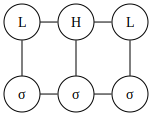

In [12]:
LHL = Autorep(reduced_mel="LHL", assoc=[(1, 1), (2, 2), (3, 3)])
LHL.draw("float")



## Part 2 Implement BUFIA on two languages: Hausa and Kanuri
---


processed 664 words, found 26 ASRs in hausa.txt
H, [(1, 1), (1, 2)]


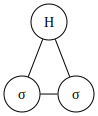

LH, [(1, 1), (2, 2)]


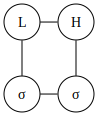

HL, [(1, 1), (2, 2)]


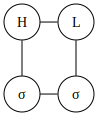

LH, [(1, 1), (2, 2), (2, 3)]


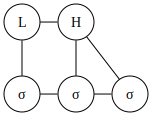

LHL, [(1, 1), (2, 2), (3, 3)]


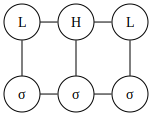

LH, [(1, 1), (1, 2), (2, 3)]


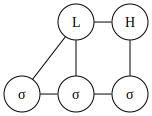

H, [(1, 1), (1, 2), (1, 3)]


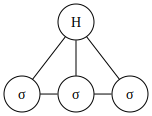

HL, [(1, 1), (1, 2), (2, 3)]


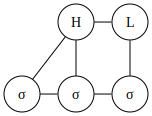

LH, [(1, 1), (1, 2), (1, 3), (2, 4)]


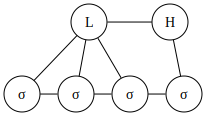

HLH, [(1, 1), (2, 2), (3, 3)]


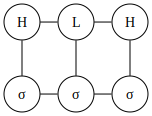

LHL, [(1, 1), (2, 2), (3, 2)]


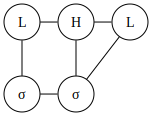

L, [(1, 1), (1, 2)]


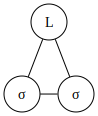

H, [(1, 1)]


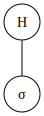

H, [(1, 1), (1, 2), (1, 3), (1, 4)]


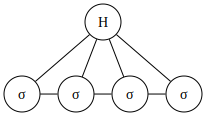

LHLH, [(1, 1), (2, 2), (3, 3), (4, 4)]


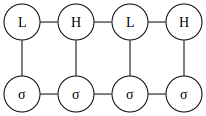

HLH, [(1, 1), (2, 1), (3, 2)]


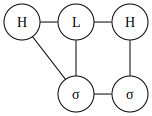

HLHL, [(1, 1), (2, 1), (3, 2), (4, 3)]


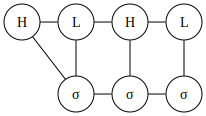

LHL, [(1, 1), (2, 2), (2, 3), (3, 4)]


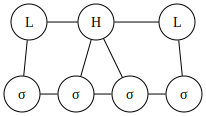

HL, [(1, 1), (2, 1)]


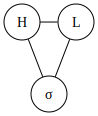

L, [(1, 1)]


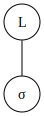

HL, [(1, 1), (1, 2), (1, 3), (2, 4)]


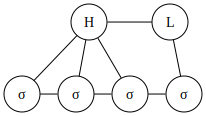

HL, [(1, 1), (1, 2), (1, 3), (1, 4), (2, 5)]


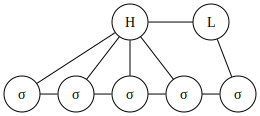

HLH, [(1, 1), (1, 2), (2, 3), (3, 4)]


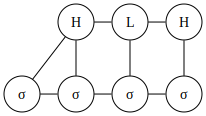

LHL, [(1, 1), (1, 2), (1, 3), (2, 4), (3, 5)]


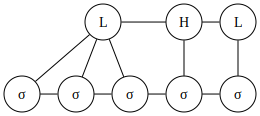

HL, [(1, 1), (2, 2), (2, 3)]


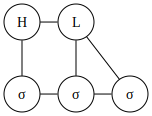

LH, [(1, 1), (2, 2), (2, 3), (2, 4)]


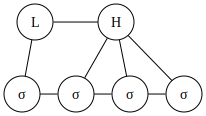

In [24]:
def convert_to_ar(filename):
    """
    Convert a text file to a list of distinct Autorep objects.
    """
    autorep_list =[]
    with open(filename, "r") as file:
        for line in file:
            autorep_list.append(Autorep(line.strip()))
            if Autorep(line.strip()).show() == empty.show():
               print(line)
    autoset = []

    for i in autorep_list:
        if i.info() not in autoset:
            autoset.append(i)
    print(f'processed {len(autorep_list)} words, found {len(autoset)} ASRs in {file.name}')
    return autoset


for i in convert_to_ar("hausa.txt"):
    print(i)
    display(i.draw())
#convert_to_ar("kanuri.txt").__str__

In [26]:
from queue import Queue

def check_from_data(ar, positive_data):
    # Iterate over each autorep in the positive data
    for i in positive_data:
        # Check if the given autorep is a sub_structure of the current autorep in the loop
        if i.check_contain(ar):
            # If it is, return True immediately
            return True
    # If the loop completes without finding any match, return False
    return False        


def check_from_grammar(ar, grammar):
    # Iterate over each autorep in the positive data
   for i in grammar:
      # Check if the given autorep contains the structure in the grammar
      if ar.check_contain(i):
         # If it is, then the grammar check fails
         return False
   # If the loop completes without finding any match, return True
   return True

 
def bufia(file, t = 2, s = 2):
   D = convert_to_ar(file)
   t_threshold = t
   s_threshold = s

   Q = Queue()
   s0 = Autorep()  
   V = []
   G = []
   Q.put(s0)

   while not Q.empty():
      s = Q.get()
      V.append(s)
      if check_from_data(s, D):
         S = s.next_ar()
         for i in S:
            if i not in V and check_from_grammar(i, G) and i.t_factor() <= t_threshold and i.s_factor() <= s_threshold:
               Q.put(i)
      else:
         if check_from_grammar(s, G):
               # only append to the grammar if it is not a super_structure of any autorep in the grammar
               G.append(s)


   print(f'found {len(G)} constraints')
   return G 

### Hausa 

processed 664 words, found 26 ASRs in hausa.txt
found 7 constraints
LH, [(1, 1), (2, 1)]


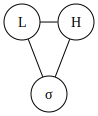

HL, [(1, 1), (1, 2), (2, 2)]


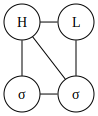

HL, [(1, 1), (2, 1), (2, 2)]


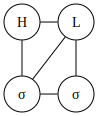

HLH, [(1, 1), (2, 2), (2, 3), (3, None)]


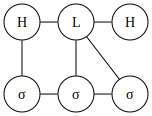

HLH, [(1, 1), (1, 2), (2, None), (1, 3), (3, None)]


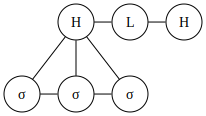

LHL, [(1, 1), (2, 2), (3, 2), (None, 3)]


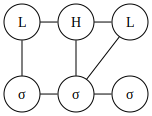

HLH, [(1, 1), (2, 1), (3, 2), (3, 3)]


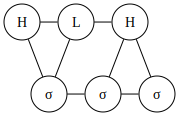

In [30]:
hausa_grammar = bufia("hausa.txt", 3, 3)
for i, cons in enumerate(hausa_grammar):
   print(cons)
   display(cons.draw(f"cons{i}"))
   

### Kanuri

bə́rbə̀r

bə́rə̀m

də̂r

nə̀kə̀lmə́skə̀

kə̀lə́gə̀

kə̀ngə́sə̀

kə́rgə́n

də́ngə̀l

tə̀mbə́r

kə́nzə́n

ngə́wə́l

də́gə́l

zə́rgə́

fə́rtə̀

kə́rzə́m

kə́lə́r

kə̀lə́sə́

ngə́rə̀m

kə́də́k

sə́lə́m

sə́mə́l

jə́mjə́m

kə̀skə̌

-a

kə̀mə́mə́gə̀

nə̀

processed 553 words, found 31 ASRs in kanuri.txt
found 14 constraints
HLH, [(1, 1), (1, 2), (2, None), (3, None)]


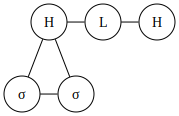

HLH, [(1, 1), (2, 1), (3, 1)]


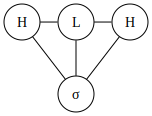

HL, [(1, 1), (1, 2), (2, 2)]


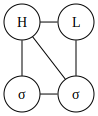

LHL, [(1, 1), (2, 1), (3, 1)]


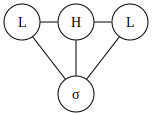

LH, [(1, 1), (1, 2), (2, 2)]


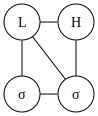

LH, [(1, 1), (2, 1), (2, 2)]


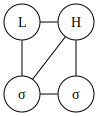

HLH, [(1, 1), (2, 1), (None, 2), (3, None), (None, 3)]


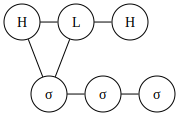

HLH, [(1, 1), (2, 2), (3, 2)]


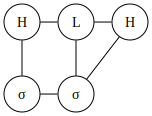

HLH, [(1, 1), (2, 1), (2, 2), (3, None)]


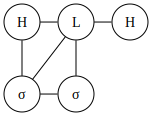

HL, [(1, 1), (1, 2), (2, None), (1, 3)]


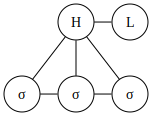

LHL, [(1, 1), (2, 1), (3, 2)]


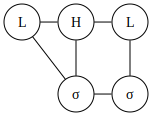

HLH, [(1, 1), (2, 2), (2, 3), (3, None)]


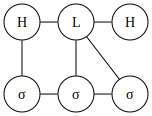

HL, [(1, 1), (2, 1), (2, 2), (2, 3)]


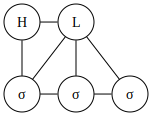

LHL, [(1, 1), (1, 2), (2, None), (1, 3), (3, None)]


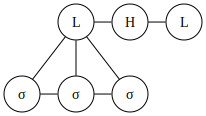

In [31]:
kanuri_grammar = bufia("kanuri.txt", 3, 3)
for i in kanuri_grammar:
   print(i)
   display(i.draw())
